## Imports




In [27]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Flatten, GaussianNoise, GaussianDropout, Conv2D, MaxPooling2D, Dropout, BatchNormalization

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sn

import time
import math
import os

## Parameters

In [2]:
num_calsses = 10
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']
input_size = (32,32,3)

## Import Data

In [3]:
(learning_images, learning_labels), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()

# shaffle learning images
np.random.seed(1234321)
permutation = np.random.choice(range(learning_images.shape[0]), learning_images.shape[0], False)
learning_images = learning_images[permutation]
learning_labels = learning_labels[permutation]

# select train and validation (20 percent)
train_images = learning_images[0:40960]
train_labels = learning_labels[0:40960]

val_images = learning_images[40960:]
val_labels = learning_labels[40960:]

# Normalize pixel values to be between 0 and 1
train_images, test_images = train_images / 255.0, test_images / 255.0

170508288/170498071 [==============================] - 2s 0us/step


In [4]:
print("Size of:")
print("- Training-set:\t\t{}".format(len(train_images)))
print("- Validtion-set:\t{}".format(len(val_images)))
print("- Test-set:\t\t{}".format(len(test_images)))

Size of:
- Training-set:		40960
- Validtion-set:	9040
- Test-set:		10000


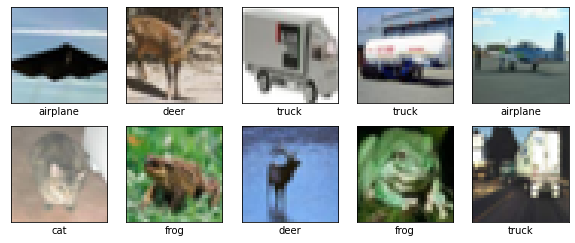

In [5]:
plt.figure(figsize=(10,4))
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(train_images[i])
    plt.xlabel(class_names[train_labels[i][0]])
plt.show()

In [6]:
# one hot
train_labels_one_hot = tf.one_hot(train_labels[:, 0].T, num_calsses)
val_labels_one_hot = tf.one_hot(val_labels[:, 0].T, num_calsses)
test_labels_one_hot = tf.one_hot(test_labels[:, 0].T, num_calsses)

In [7]:
test_labels_one_hot[0]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0.], dtype=float32)>

In [8]:
# normalize
train_images_normalized = (train_images- np.mean(train_images, axis=0)) / (1e-3 + np.sqrt(np.var(train_images, axis=0)))
val_images_normalized = (val_images- np.mean(val_images, axis=0)) / (1e-3 + np.sqrt(np.var(val_images, axis=0)))
test_images_normalized = (test_images- np.mean(test_images, axis=0)) / (1e-3 + np.sqrt(np.var(test_images, axis=0)))

# MLP

## A) Stochastic mini batch based

In [9]:
batch_size = [32, 64, 256]

In [35]:
model = Sequential()    # actually tf.keras.models.Sequential

reg = tf.keras.regularizers.L1L2(
    l1=0.00001, l2=0.0001
)

model.add(Input(shape=input_size))    # Input layer 32*32*3
model.add(Flatten())
model.add(GaussianNoise(0.1))
model.add(Dense(1024, activation = 'relu', kernel_regularizer=reg))   # Hidden 32*32*3 -> 1024
model.add(GaussianDropout(0.4))
model.add(Dense(256, activation = 'relu', kernel_regularizer=reg))    # Hidden 1024 -> 256
model.add(Dropout(0.25))
model.add(Dense(10, activation = 'softmax', kernel_regularizer=reg))  # OUTPUT 256 -> 10

opt = tf.keras.optimizers.SGD(learning_rate=0.01)
model.compile(optimizer = opt, loss = 'categorical_crossentropy', metrics='accuracy')

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 3072)              0         
                                                                 
 gaussian_noise (GaussianNoi  (None, 3072)             0         
 se)                                                             
                                                                 
 dense (Dense)               (None, 1024)              3146752   
                                                                 
 gaussian_dropout (GaussianD  (None, 1024)             0         
 ropout)                                                         
                                                                 
 dense_1 (Dense)             (None, 256)               262400    
                                                                 
 dropout (Dropout)           (None, 256)               0

In [12]:
# Callbacks definition
def scheduler(epoch, lr):
   if epoch < 2:
     return lr
   else:
     return lr / 1.005

lr_cb = tf.keras.callbacks.LearningRateScheduler(scheduler)


In [ ]:
# class CustomCallback(tf.keras.callbacks.Callback):

#   def __init__(self, patience=0):
      
#       # define learning and validation accuracy 
#       self.acc_train = []
#       self.acc_val = []

#   def on_epoch_end(self, epoch, logs=None):
#       keys = list(logs.keys())
#       self.acc_train.append(logs['accuracy'])
#       self.acc_val.append(logs['val_accuracy'])

#   def on_train_end(self, epoch, logs=None):


#       print(self.acc_train)
#       print(self.acc_val)

#       plt.plot(range(epoch), acc_train)
#       plt.hold_on
#       plt.plot(range(epoch), acc_val)
#       plt.show


### Batch size 32

In [13]:
history = model.fit(
    x=train_images_normalized, y=train_labels_one_hot, batch_size=batch_size[0], epochs=40, verbose='auto',
    callbacks=[lr_cb], validation_split=0.0, validation_data=(val_images_normalized, val_labels_one_hot), shuffle=True,
    class_weight=None, sample_weight=None, initial_epoch=0, steps_per_epoch=None,
    validation_steps=None, validation_batch_size=None, validation_freq=1,
    max_queue_size=10, workers=1, use_multiprocessing=False
)
model.save('./drive/MyDrive/DeepLearning_HW2/CNN_MLP/models/batch_size_32')

hist_df = pd.DataFrame(history.history)
with open('./drive/MyDrive/DeepLearning_HW2/CNN_MLP/models/batch_size_32/history.csv', mode='w') as f:
    hist_df.to_csv(f)

Epoch 1/40
1280/1280 [==============================] - 12s 8ms/step - loss: 2.7610 - accuracy: 0.3404 - val_loss: 2.5064 - val_accuracy: 0.4310 - lr: 0.0100
Epoch 2/40
1280/1280 [==============================] - 9s 7ms/step - loss: 2.5337 - accuracy: 0.4142 - val_loss: 2.4311 - val_accuracy: 0.4499 - lr: 0.0100
Epoch 3/40
1280/1280 [==============================] - 9s 7ms/step - loss: 2.4386 - accuracy: 0.4474 - val_loss: 2.3634 - val_accuracy: 0.4737 - lr: 0.0100
Epoch 4/40
1280/1280 [==============================] - 9s 7ms/step - loss: 2.3730 - accuracy: 0.4683 - val_loss: 2.3181 - val_accuracy: 0.4845 - lr: 0.0099
Epoch 5/40
1280/1280 [==============================] - 9s 7ms/step - loss: 2.3133 - accuracy: 0.4855 - val_loss: 2.3010 - val_accuracy: 0.4918 - lr: 0.0099
Epoch 6/40
1280/1280 [==============================] - 9s 7ms/step - loss: 2.2742 - accuracy: 0.4959 - val_loss: 2.2591 - val_accuracy: 0.4996 - lr: 0.0098
Epoch 7/40
1280/1280 [==============================] - 1

### Batch size 64

In [34]:
history = model.fit(
    x=train_images_normalized, y=train_labels_one_hot, batch_size=batch_size[1], epochs=40, verbose='auto',
    callbacks=[lr_cb], validation_split=0.0, validation_data=(val_images_normalized, val_labels_one_hot), shuffle=True,
    class_weight=None, sample_weight=None, initial_epoch=0, steps_per_epoch=None,
    validation_steps=None, validation_batch_size=None, validation_freq=1,
    max_queue_size=10, workers=1, use_multiprocessing=False
)
model.save('./drive/MyDrive/DeepLearning_HW2/CNN_MLP/models/batch_size_64')

hist_df = pd.DataFrame(history.history)
with open('./drive/MyDrive/DeepLearning_HW2/CNN_MLP/models/batch_size_64/history.csv', mode='w') as f:
    hist_df.to_csv(f)

Epoch 1/40
640/640 [==============================] - 6s 8ms/step - loss: 2.8348 - accuracy: 0.3179 - val_loss: 2.5367 - val_accuracy: 0.4294 - lr: 0.0100
Epoch 2/40
640/640 [==============================] - 5s 8ms/step - loss: 2.5856 - accuracy: 0.3937 - val_loss: 2.4674 - val_accuracy: 0.4417 - lr: 0.0100
Epoch 3/40
640/640 [==============================] - 5s 8ms/step - loss: 2.4969 - accuracy: 0.4292 - val_loss: 2.4133 - val_accuracy: 0.4644 - lr: 0.0100
Epoch 4/40
640/640 [==============================] - 5s 8ms/step - loss: 2.4372 - accuracy: 0.4484 - val_loss: 2.3740 - val_accuracy: 0.4741 - lr: 0.0099
Epoch 5/40
640/640 [==============================] - 5s 8ms/step - loss: 2.3923 - accuracy: 0.4625 - val_loss: 2.3486 - val_accuracy: 0.4834 - lr: 0.0099
Epoch 6/40
640/640 [==============================] - 6s 9ms/step - loss: 2.3540 - accuracy: 0.4758 - val_loss: 2.3181 - val_accuracy: 0.4858 - lr: 0.0098
Epoch 7/40
640/640 [==============================] - 5s 8ms/step - lo

### Batch size 256

In [36]:
history = model.fit(
    x=train_images_normalized, y=train_labels_one_hot, batch_size=batch_size[2], epochs=40, verbose='auto',
    callbacks=[lr_cb], validation_split=0.0, validation_data=(val_images_normalized, val_labels_one_hot), shuffle=True,
    class_weight=None, sample_weight=None, initial_epoch=0, steps_per_epoch=None,
    validation_steps=None, validation_batch_size=None, validation_freq=1,
    max_queue_size=10, workers=1, use_multiprocessing=False
)
model.save('./drive/MyDrive/DeepLearning_HW2/CNN_MLP/models/batch_size_256')

hist_df = pd.DataFrame(history.history)
with open('./drive/MyDrive/DeepLearning_HW2/CNN_MLP/models/batch_size_256/history.csv', mode='w') as f:
    hist_df.to_csv(f)

Epoch 1/40
160/160 [==============================] - 3s 13ms/step - loss: 3.0820 - accuracy: 0.2552 - val_loss: 2.6625 - val_accuracy: 0.3765 - lr: 0.0100
Epoch 2/40
160/160 [==============================] - 2s 11ms/step - loss: 2.7872 - accuracy: 0.3346 - val_loss: 2.5921 - val_accuracy: 0.4037 - lr: 0.0100
Epoch 3/40
160/160 [==============================] - 2s 11ms/step - loss: 2.6787 - accuracy: 0.3660 - val_loss: 2.5476 - val_accuracy: 0.4143 - lr: 0.0100
Epoch 4/40
160/160 [==============================] - 2s 11ms/step - loss: 2.6225 - accuracy: 0.3858 - val_loss: 2.5152 - val_accuracy: 0.4253 - lr: 0.0099
Epoch 5/40
160/160 [==============================] - 2s 11ms/step - loss: 2.5803 - accuracy: 0.4003 - val_loss: 2.4883 - val_accuracy: 0.4304 - lr: 0.0099
Epoch 6/40
160/160 [==============================] - 2s 10ms/step - loss: 2.5492 - accuracy: 0.4082 - val_loss: 2.4665 - val_accuracy: 0.4421 - lr: 0.0098
Epoch 7/40
160/160 [==============================] - 2s 11ms/st

## B) Use TanH

In [37]:
model = Sequential()    # actually tf.keras.models.Sequential

reg = tf.keras.regularizers.L1L2(
    l1=0.00001, l2=0.0001
)

model.add(Input(shape=input_size))    # Input layer 32*32*3
model.add(Flatten())
model.add(GaussianNoise(0.1))
model.add(Dense(1024, activation = 'tanh', kernel_regularizer=reg))   # Hidden 32*32*3 -> 1024
model.add(GaussianDropout(0.4))
model.add(Dense(256, activation = 'tanh', kernel_regularizer=reg))    # Hidden 1024 -> 256
model.add(Dropout(0.25))
model.add(Dense(10, activation = 'softmax', kernel_regularizer=reg))  # OUTPUT 256 -> 10

opt = tf.keras.optimizers.SGD(learning_rate=0.01)
model.compile(optimizer = opt, loss = 'categorical_crossentropy', metrics='accuracy')

In [38]:
history = model.fit(
    x=train_images_normalized, y=train_labels_one_hot, batch_size=batch_size[0], epochs=40, verbose='auto',
    callbacks=[lr_cb], validation_split=0.0, validation_data=(val_images_normalized, val_labels_one_hot), shuffle=True,
    class_weight=None, sample_weight=None, initial_epoch=0, steps_per_epoch=None,
    validation_steps=None, validation_batch_size=None, validation_freq=1,
    max_queue_size=10, workers=1, use_multiprocessing=False
)
model.save('./drive/MyDrive/DeepLearning_HW2/CNN_MLP/models/activation_function_tanh')

hist_df = pd.DataFrame(history.history)
with open('./drive/MyDrive/DeepLearning_HW2/CNN_MLP/models/activation_function_tanh/history.csv', mode='w') as f:
    hist_df.to_csv(f)

Epoch 1/40
1280/1280 [==============================] - 10s 7ms/step - loss: 2.8400 - accuracy: 0.3251 - val_loss: 2.6010 - val_accuracy: 0.4060 - lr: 0.0100
Epoch 2/40
1280/1280 [==============================] - 9s 7ms/step - loss: 2.6334 - accuracy: 0.3890 - val_loss: 2.5501 - val_accuracy: 0.4228 - lr: 0.0100
Epoch 3/40
1280/1280 [==============================] - 9s 7ms/step - loss: 2.5522 - accuracy: 0.4144 - val_loss: 2.5262 - val_accuracy: 0.4261 - lr: 0.0100
Epoch 4/40
1280/1280 [==============================] - 9s 7ms/step - loss: 2.5065 - accuracy: 0.4303 - val_loss: 2.4891 - val_accuracy: 0.4378 - lr: 0.0099
Epoch 5/40
1280/1280 [==============================] - 9s 7ms/step - loss: 2.4711 - accuracy: 0.4410 - val_loss: 2.4608 - val_accuracy: 0.4423 - lr: 0.0099
Epoch 6/40
1280/1280 [==============================] - 9s 7ms/step - loss: 2.4333 - accuracy: 0.4517 - val_loss: 2.4382 - val_accuracy: 0.4543 - lr: 0.0098
Epoch 7/40
1280/1280 [==============================] - 9

# C) Use MSE loss function

In [46]:
model = Sequential()    # actually tf.keras.models.Sequential

reg = tf.keras.regularizers.L1L2(
    l1=0.00001, l2=0.0001
)

model.add(Input(shape=input_size))    # Input layer 32*32*3
model.add(Flatten())
model.add(GaussianNoise(0.1))
model.add(Dense(1024, activation = 'relu', kernel_regularizer=reg))   # Hidden 32*32*3 -> 1024
model.add(GaussianDropout(0.4))
model.add(Dense(256, activation = 'relu', kernel_regularizer=reg))    # Hidden 1024 -> 256
model.add(Dropout(0.25))
model.add(Dense(10, activation = 'softmax', kernel_regularizer=reg))  # OUTPUT 256 -> 10

opt = tf.keras.optimizers.SGD(learning_rate=0.01)
model.compile(optimizer = opt, loss = 'mean_squared_error', metrics='accuracy')

In [47]:
history = model.fit(
    x=train_images_normalized, y=train_labels_one_hot, batch_size=batch_size[0], epochs=40, verbose='auto',
    callbacks=[lr_cb], validation_split=0.0, validation_data=(val_images_normalized, val_labels_one_hot), shuffle=True,
    class_weight=None, sample_weight=None, initial_epoch=0, steps_per_epoch=None,
    validation_steps=None, validation_batch_size=None, validation_freq=1,
    max_queue_size=10, workers=1, use_multiprocessing=False
)
model.save('./drive/MyDrive/DeepLearning_HW2/CNN_MLP/models/loss_function_mse')

hist_df = pd.DataFrame(history.history)
with open('./drive/MyDrive/DeepLearning_HW2/CNN_MLP/models/loss_function_mse/history.csv', mode='w') as f:
    hist_df.to_csv(f)

Epoch 1/40
1280/1280 [==============================] - 12s 9ms/step - loss: 0.9812 - accuracy: 0.1696 - val_loss: 0.9635 - val_accuracy: 0.2869 - lr: 0.0100
Epoch 2/40
1280/1280 [==============================] - 11s 8ms/step - loss: 0.9644 - accuracy: 0.2464 - val_loss: 0.9511 - val_accuracy: 0.3427 - lr: 0.0100
Epoch 3/40
1280/1280 [==============================] - 10s 8ms/step - loss: 0.9522 - accuracy: 0.2832 - val_loss: 0.9405 - val_accuracy: 0.3640 - lr: 0.0100
Epoch 4/40
1280/1280 [==============================] - 9s 7ms/step - loss: 0.9410 - accuracy: 0.3068 - val_loss: 0.9307 - val_accuracy: 0.3765 - lr: 0.0099
Epoch 5/40
1280/1280 [==============================] - 9s 7ms/step - loss: 0.9309 - accuracy: 0.3196 - val_loss: 0.9212 - val_accuracy: 0.3855 - lr: 0.0099
Epoch 6/40
1280/1280 [==============================] - 9s 7ms/step - loss: 0.9210 - accuracy: 0.3371 - val_loss: 0.9120 - val_accuracy: 0.3933 - lr: 0.0098
Epoch 7/40
1280/1280 [==============================] -

## D) Adam optimizer

In [50]:
model = Sequential()    # actually tf.keras.models.Sequential

reg = tf.keras.regularizers.L1L2(
    l1=0.00001, l2=0.0001
)

model.add(Input(shape=input_size))    # Input layer 32*32*3
model.add(Flatten())
model.add(GaussianNoise(0.1))
model.add(Dense(1024, activation = 'relu', kernel_regularizer=reg))   # Hidden 32*32*3 -> 1024
model.add(GaussianDropout(0.4))
model.add(Dense(256, activation = 'relu', kernel_regularizer=reg))    # Hidden 1024 -> 256
model.add(Dropout(0.25))
model.add(Dense(10, activation = 'softmax', kernel_regularizer=reg))  # OUTPUT 256 -> 10

opt = tf.keras.optimizers.Adam(learning_rate=0.01)
model.compile(optimizer = opt, loss = 'categorical_crossentropy', metrics='accuracy')

In [51]:
history = model.fit(
    x=train_images_normalized, y=train_labels_one_hot, batch_size=batch_size[0], epochs=40, verbose='auto',
    callbacks=[lr_cb], validation_split=0.0, validation_data=(val_images_normalized, val_labels_one_hot), shuffle=True,
    class_weight=None, sample_weight=None, initial_epoch=0, steps_per_epoch=None,
    validation_steps=None, validation_batch_size=None, validation_freq=1,
    max_queue_size=10, workers=1, use_multiprocessing=False
)
model.save('./drive/MyDrive/DeepLearning_HW2/CNN_MLP/models/optimizer_adam')

hist_df = pd.DataFrame(history.history)
with open('./drive/MyDrive/DeepLearning_HW2/CNN_MLP/models/optimizer_adam/history.csv', mode='w') as f:
    hist_df.to_csv(f)

Epoch 1/40
1280/1280 [==============================] - 13s 9ms/step - loss: 3.5799 - accuracy: 0.1007 - val_loss: 3.0837 - val_accuracy: 0.1021 - lr: 0.0100
Epoch 2/40
1280/1280 [==============================] - 14s 11ms/step - loss: 3.0604 - accuracy: 0.1008 - val_loss: 3.4112 - val_accuracy: 0.0961 - lr: 0.0100
Epoch 3/40
1280/1280 [==============================] - 10s 8ms/step - loss: 3.1827 - accuracy: 0.0987 - val_loss: 3.2799 - val_accuracy: 0.0970 - lr: 0.0100
Epoch 4/40
1280/1280 [==============================] - 10s 8ms/step - loss: 3.3558 - accuracy: 0.0996 - val_loss: 3.2498 - val_accuracy: 0.1001 - lr: 0.0099
Epoch 5/40
1280/1280 [==============================] - 10s 8ms/step - loss: 3.4265 - accuracy: 0.0993 - val_loss: 3.7608 - val_accuracy: 0.1010 - lr: 0.0099
Epoch 6/40
1280/1280 [==============================] - 10s 8ms/step - loss: 3.4041 - accuracy: 0.1009 - val_loss: 3.4652 - val_accuracy: 0.0947 - lr: 0.0098
Epoch 7/40
1280/1280 [=============================

## E) Best model
In our case, batch_size_32 is the best model with reLU and categorical_crossentropy

In [55]:
class F_score(tf.keras.metrics.Metric):
  def __init__(self, **kwargs):
    super(F_score, self).__init__(**kwargs)
  def update_state(self, y_true, y_pred, sample_weight=None):
    self.confusion_matrix = tf.math.confusion_matrix(tf.math.argmax(y_true, axis=-1), tf.math.argmax(y_pred, axis=-1), num_calsses)
    self.precision = tf.linalg.diag_part(tf.transpose(self.confusion_matrix)/tf.reshape(tf.math.reduce_sum(self.confusion_matrix, axis=0), (-1, 1)))
    self.recall = tf.linalg.diag_part(self.confusion_matrix/tf.reshape(tf.math.reduce_sum(self.confusion_matrix, axis=-1), (-1, 1)))
    self.F_score = 2*self.precision*self.precision/(self.precision+self.recall)
  def result(self):
    return tf.reduce_mean(self.F_score)
  def reset_state(self):
    self.confusion_matrix = None
    self.precision = None
    self.recall = None
    self.F_score = None

model = Sequential()    # actually tf.keras.models.Sequential

reg = tf.keras.regularizers.L1L2(
    l1=0.00001, l2=0.0001
)

model.add(Input(shape=input_size))    # Input layer 32*32*3
model.add(Flatten())
model.add(GaussianNoise(0.1))
model.add(Dense(1024, activation = 'relu', kernel_regularizer=reg))   # Hidden 32*32*3 -> 1024
model.add(GaussianDropout(0.4))
model.add(Dense(256, activation = 'relu', kernel_regularizer=reg))    # Hidden 1024 -> 256
model.add(Dropout(0.25))
model.add(Dense(10, activation = 'softmax', kernel_regularizer=reg))  # OUTPUT 256 -> 10

opt = tf.keras.optimizers.SGD(learning_rate=0.0)
model.compile(optimizer = opt, loss = ' ', metrics=['accuracy', tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall'), F_score(name='F_score')])

In [56]:
history = model.fit(
    x=train_images_normalized, y=train_labels_one_hot, batch_size=batch_size[0], epochs=50, verbose='auto',
    callbacks=[lr_cb], validation_split=0.0, validation_data=(val_images_normalized, val_labels_one_hot), shuffle=True,
    class_weight=None, sample_weight=None, initial_epoch=0, steps_per_epoch=None,
    validation_steps=None, validation_batch_size=None, validation_freq=1,
    max_queue_size=10, workers=1, use_multiprocessing=False
)
model.save('./drive/MyDrive/DeepLearning_HW2/CNN_MLP/models/best_model')

hist_df = pd.DataFrame(history.history)
with open('./drive/MyDrive/DeepLearning_HW2/CNN_MLP/models/best_model/history.csv', mode='w') as f:
    hist_df.to_csv(f)

Epoch 1/50
1280/1280 [==============================] - 19s 13ms/step - loss: 2.7248 - accuracy: 0.3471 - precision: 0.5369 - recall: 0.1249 - F_score: nan - val_loss: 2.5274 - val_accuracy: 0.4038 - val_precision: 0.6892 - val_recall: 0.1148 - val_F_score: nan - lr: 0.0500
Epoch 2/50
1280/1280 [==============================] - 23s 18ms/step - loss: 2.5209 - accuracy: 0.4015 - precision: 0.6038 - recall: 0.1821 - F_score: nan - val_loss: 2.4369 - val_accuracy: 0.4197 - val_precision: 0.6834 - val_recall: 0.1569 - val_F_score: nan - lr: 0.0500
Epoch 3/50
1280/1280 [==============================] - 22s 17ms/step - loss: 2.4220 - accuracy: 0.4277 - precision: 0.6238 - recall: 0.2141 - F_score: nan - val_loss: 2.3289 - val_accuracy: 0.4569 - val_precision: 0.7213 - val_recall: 0.1878 - val_F_score: nan - lr: 0.0498
Epoch 4/50
1280/1280 [==============================] - 21s 17ms/step - loss: 2.3448 - accuracy: 0.4421 - precision: 0.6436 - recall: 0.2363 - F_score: nan - val_loss: 2.2979 

1/1 [==============================] - 1s 724ms/step - loss: 1.7956 - accuracy: 0.5365 - precision: 0.6958 - recall: 0.3922 - F_score: 0.5574
Test Loss =  1.7955983877182007
Test Accuracy =  0.5364999771118164
Test Precision =  0.6957601308822632
Test Recall =  0.3921999931335449
Test F_score =  0.5574224344927078


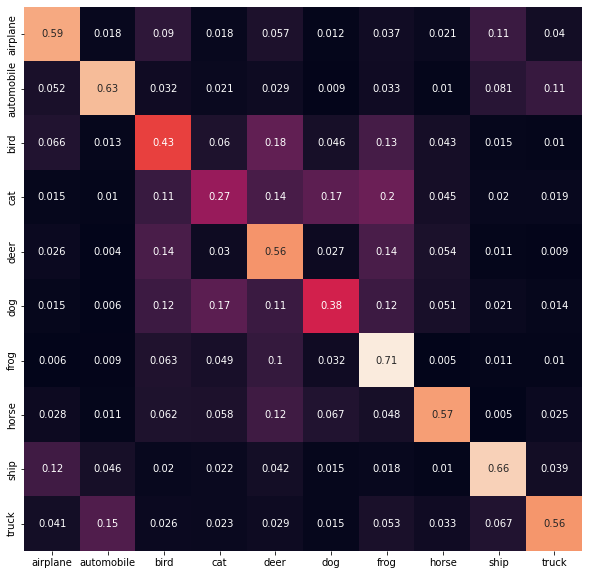

In [57]:
model = tf.keras.models.load_model('./drive/MyDrive/DeepLearning_HW2/CNN_MLP/models/best_model', custom_objects={'F_score': F_score})

[test_loss, test_accuracy, test_precision, test_recall, test_F_score] = model.evaluate(test_images_normalized, test_labels_one_hot, batch_size=len(test_images_normalized))
print('Test Loss = ', test_loss)
print('Test Accuracy = ', test_accuracy)
print('Test Precision = ', test_precision)
print('Test Recall = ', test_recall)
print('Test F_score = ', test_F_score)

predicted_Y_test = model.predict(test_images_normalized)
confusion_matrix = tf.math.confusion_matrix(test_labels, np.argmax(predicted_Y_test, axis=-1), num_calsses).numpy()
confusion_matrix = confusion_matrix/confusion_matrix.sum(axis=1)
df = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names)
plt.figure(figsize=(10, 10))
sn.heatmap(df, annot=True, cbar=False)

## G) Solving unbalanced dataset problem

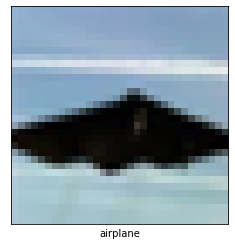

In [69]:
plt.figure(figsize=(4,4))
plt.xticks([])
plt.yticks([])
plt.imshow(train_images[0])
plt.xlabel(class_names[train_labels[0][0]])
plt.show()

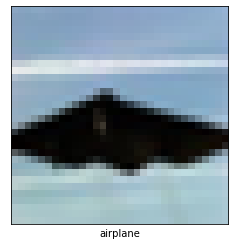

In [79]:
plt.figure(figsize=(4,4))
plt.xticks([])
plt.yticks([])
plt.imshow(np.flip(train_images[0], axis = 1))
plt.xlabel(class_names[train_labels[0][0]])
plt.show()

In [86]:
# Unbalance and again balance dataset

bird_counter = 0
bird_temp = train_images[0]
airplane_counter = 0
airplane_temp = train_images[0]

new_train_images = train_images;

for i in range(len(train_labels)) :
  if(class_names[train_labels[i][0]] == 'airplane'):
    airplane_counter += 1
    if(airplane_counter%2==1):
      airplane_temp = train_images[i]
    else:
      new_train_images[i] = np.flip(airplane_temp, axis = 1)

  if(class_names[train_labels[i][0]] == 'bird'):
    bird_counter += 1
    if(airplane_counter%2==1):
      bird_temp = train_images[i]
    else:
      new_train_images[i] = np.flip(bird_temp, axis = 1)

# normalize
new_train_images_normalized = (new_train_images- np.mean(new_train_images, axis=0)) / (1e-3 + np.sqrt(np.var(new_train_images, axis=0)))


In [87]:
model = Sequential()    # actually tf.keras.models.Sequential

reg = tf.keras.regularizers.L1L2(
    l1=0.00001, l2=0.0001
)

model.add(Input(shape=input_size))    # Input layer 32*32*3
model.add(Flatten())
model.add(GaussianNoise(0.1))
model.add(Dense(1024, activation = 'relu', kernel_regularizer=reg))   # Hidden 32*32*3 -> 1024
model.add(GaussianDropout(0.4))
model.add(Dense(256, activation = 'relu', kernel_regularizer=reg))    # Hidden 1024 -> 256
model.add(Dropout(0.25))
model.add(Dense(10, activation = 'softmax', kernel_regularizer=reg))  # OUTPUT 256 -> 10

opt = tf.keras.optimizers.SGD(learning_rate=0.01)
model.compile(optimizer = opt, loss = 'categorical_crossentropy', metrics='accuracy')

In [88]:
history = model.fit(
    x=new_train_images_normalized, y=train_labels_one_hot, batch_size=batch_size[0], epochs=50, verbose='auto',
    callbacks=[lr_cb], validation_split=0.0, validation_data=(val_images_normalized, val_labels_one_hot), shuffle=True,
    class_weight=None, sample_weight=None, initial_epoch=0, steps_per_epoch=None,
    validation_steps=None, validation_batch_size=None, validation_freq=1,
    max_queue_size=10, workers=1, use_multiprocessing=False
)
model.save('./drive/MyDrive/DeepLearning_HW2/CNN_MLP/models/unbalanced_dataset')

hist_df = pd.DataFrame(history.history)
with open('./drive/MyDrive/DeepLearning_HW2/CNN_MLP/models/unbalanced_dataset/history.csv', mode='w') as f:
    hist_df.to_csv(f)

Epoch 1/50
1280/1280 [==============================] - 13s 10ms/step - loss: 2.7518 - accuracy: 0.3476 - val_loss: 2.5044 - val_accuracy: 0.4366 - lr: 0.0100
Epoch 2/50
1280/1280 [==============================] - 15s 11ms/step - loss: 2.5124 - accuracy: 0.4219 - val_loss: 2.4211 - val_accuracy: 0.4585 - lr: 0.0100
Epoch 3/50
1280/1280 [==============================] - 10s 8ms/step - loss: 2.4209 - accuracy: 0.4506 - val_loss: 2.3839 - val_accuracy: 0.4662 - lr: 0.0100
Epoch 4/50
1280/1280 [==============================] - 10s 8ms/step - loss: 2.3586 - accuracy: 0.4706 - val_loss: 2.3289 - val_accuracy: 0.4821 - lr: 0.0099
Epoch 5/50
1280/1280 [==============================] - 10s 8ms/step - loss: 2.3009 - accuracy: 0.4888 - val_loss: 2.3091 - val_accuracy: 0.4812 - lr: 0.0099
Epoch 6/50
1280/1280 [==============================] - 10s 8ms/step - loss: 2.2575 - accuracy: 0.5034 - val_loss: 2.2745 - val_accuracy: 0.4904 - lr: 0.0098
Epoch 7/50
1280/1280 [============================

# In this part you can get output of your network
After running each part you can run this part to visualize the result

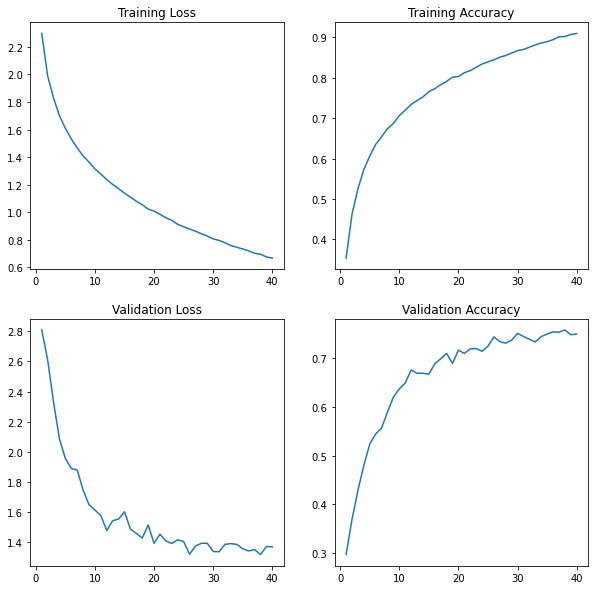

In [119]:
history = pd.read_csv('./drive/MyDrive/DeepLearning_HW2/CNN_MLP/models/cnn_pooling_bn_dropout/history.csv')
plt.rcParams['figure.figsize'] = [10, 10]
fig = plt.figure()
ax = fig.add_subplot(2, 2, 1)
ax.set_title('Training Loss')
plt.plot(range(1, len(history['loss']) + 1), history['loss'])
ax = fig.add_subplot(2, 2, 2)
ax.set_title('Training Accuracy')
plt.plot(range(1, len(history['accuracy']) + 1), history['accuracy'])
ax = fig.add_subplot(2, 2, 3)
ax.set_title('Validation Loss')
plt.plot(range(1, len(history['val_loss']) + 1), history['val_loss'])
ax = fig.add_subplot(2, 2, 4)
ax.set_title('Validation Accuracy')
plt.plot(range(1, len(history['val_accuracy']) + 1), history['val_accuracy'])

313/313 [==============================] - 3s 10ms/step - loss: 1.3397 - accuracy: 0.7577
Test Loss =  1.339733600616455
Test Accuracy =  0.7577000260353088


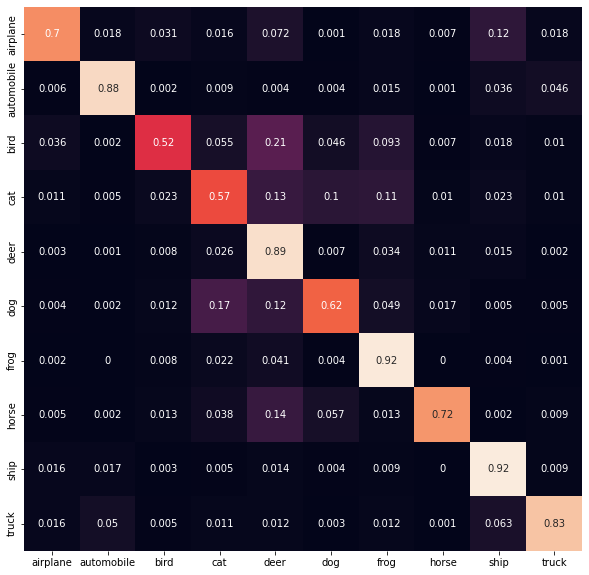

In [120]:
# Confusion matrix
model = tf.keras.models.load_model('./drive/MyDrive/DeepLearning_HW2/CNN_MLP/models/cnn_pooling_bn_dropout')
[test_loss, test_accuracy] = model.evaluate(test_images_normalized, test_labels_one_hot)
print('Test Loss = ', test_loss)
print('Test Accuracy = ', test_accuracy)
predicted_Y_test = model.predict(test_images_normalized)
confusion_matrix = tf.math.confusion_matrix(test_labels, np.argmax(predicted_Y_test, axis=-1), num_calsses).numpy()
confusion_matrix = confusion_matrix/confusion_matrix.sum(axis=1)
df = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names)
plt.figure(figsize=(10, 10))
sn.heatmap(df, annot=True, cbar=False)

## CNN

In [101]:
model = Sequential()    # actually tf.keras.models.Sequential

reg = tf.keras.regularizers.L1L2(
    l1=0.00001, l2=0.0001
)

model = Sequential()
model.add(Conv2D(128, (5, 5), activation='relu', input_shape=(32, 32, 3)))

model.add(Conv2D(64, (5, 5), activation='relu'))

model.add(Conv2D(64, (5, 5), activation='relu'))


model.add(Flatten())
model.add(GaussianNoise(0.1))
model.add(Dense(1024, activation = 'relu', kernel_regularizer=reg))   # Hidden 32*32*3 -> 1024
model.add(GaussianDropout(0.4))
model.add(Dense(256, activation = 'relu', kernel_regularizer=reg))    # Hidden 1024 -> 256
model.add(Dropout(0.25))
model.add(Dense(10, activation = 'softmax', kernel_regularizer=reg))  # OUTPUT 256 -> 10

opt = tf.keras.optimizers.SGD(learning_rate=0.01)
model.compile(optimizer = opt, loss = 'categorical_crossentropy', metrics='accuracy')

In [102]:
model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 28, 28, 128)       9728      
                                                                 
 conv2d_7 (Conv2D)           (None, 24, 24, 64)        204864    
                                                                 
 conv2d_8 (Conv2D)           (None, 20, 20, 64)        102464    
                                                                 
 flatten_11 (Flatten)        (None, 25600)             0         
                                                                 
 gaussian_noise_11 (Gaussian  (None, 25600)            0         
 Noise)                                                          
                                                                 
 dense_33 (Dense)            (None, 1024)              26215424  
                                                     

In [100]:
# Callbacks definition
def scheduler(epoch, lr):
   if epoch < 3:
     return lr
   else:
     return lr / 1.01

lr_cb = tf.keras.callbacks.LearningRateScheduler(scheduler)


In [103]:
history = model.fit(
    x=train_images_normalized, y=train_labels_one_hot, batch_size=batch_size[0], epochs=40, verbose='auto',
    callbacks=[lr_cb], validation_split=0.0, validation_data=(val_images_normalized, val_labels_one_hot), shuffle=True,
    class_weight=None, sample_weight=None, initial_epoch=0, steps_per_epoch=None,
    validation_steps=None, validation_batch_size=None, validation_freq=1,
    max_queue_size=10, workers=1, use_multiprocessing=False
)

model.save('./drive/MyDrive/DeepLearning_HW2/CNN_MLP/models/cnn')

hist_df = pd.DataFrame(history.history)
with open('./drive/MyDrive/DeepLearning_HW2/CNN_MLP/models/cnn/history.csv', mode='w') as f:
    hist_df.to_csv(f)

Epoch 1/40
1280/1280 [==============================] - 56s 43ms/step - loss: 4.0093 - accuracy: 0.3650 - val_loss: 3.6971 - val_accuracy: 0.4760 - lr: 0.0100
Epoch 2/40
1280/1280 [==============================] - 54s 42ms/step - loss: 3.6409 - accuracy: 0.4919 - val_loss: 3.4972 - val_accuracy: 0.5450 - lr: 0.0100
Epoch 3/40
1280/1280 [==============================] - 55s 43ms/step - loss: 3.4497 - accuracy: 0.5535 - val_loss: 3.3249 - val_accuracy: 0.5960 - lr: 0.0100
Epoch 4/40
1280/1280 [==============================] - 54s 42ms/step - loss: 3.2796 - accuracy: 0.6022 - val_loss: 3.2012 - val_accuracy: 0.6236 - lr: 0.0099
Epoch 5/40
1280/1280 [==============================] - 54s 42ms/step - loss: 3.1317 - accuracy: 0.6412 - val_loss: 3.1065 - val_accuracy: 0.6447 - lr: 0.0098
Epoch 6/40
1280/1280 [==============================] - 54s 42ms/step - loss: 3.0040 - accuracy: 0.6721 - val_loss: 3.0186 - val_accuracy: 0.6644 - lr: 0.0097
Epoch 7/40
1280/1280 [========================

## Add Pooling and Batch normalization

In [107]:
model = Sequential()    # actually tf.keras.models.Sequential

reg = tf.keras.regularizers.L1L2(
    l1=0.00001, l2=0.0001
)

model = Sequential()
model.add(Conv2D(128, (5, 5), activation='relu', input_shape=(32, 32, 3)))
model.add(BatchNormalization())

model.add(Conv2D(64, (5, 5), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (5, 5), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))


model.add(Flatten())
model.add(GaussianNoise(0.1))
model.add(Dense(1024, activation = 'relu', kernel_regularizer=reg))   # Hidden 32*32*3 -> 1024
model.add(GaussianDropout(0.4))
model.add(Dense(256, activation = 'relu', kernel_regularizer=reg))    # Hidden 1024 -> 256
model.add(Dropout(0.25))
model.add(Dense(10, activation = 'softmax', kernel_regularizer=reg))  # OUTPUT 256 -> 10

opt = tf.keras.optimizers.SGD(learning_rate=0.01)
model.compile(optimizer = opt, loss = 'categorical_crossentropy', metrics='accuracy')

In [108]:
model.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 28, 28, 128)       9728      
                                                                 
 batch_normalization_3 (Batc  (None, 28, 28, 128)      512       
 hNormalization)                                                 
                                                                 
 conv2d_13 (Conv2D)          (None, 24, 24, 64)        204864    
                                                                 
 batch_normalization_4 (Batc  (None, 24, 24, 64)       256       
 hNormalization)                                                 
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 12, 12, 64)       0         
 2D)                                                             
                                                     

In [110]:
history = model.fit(
    x=train_images_normalized, y=train_labels_one_hot, batch_size=batch_size[0], epochs=40, verbose='auto',
    callbacks=[lr_cb], validation_split=0.0, validation_data=(val_images_normalized, val_labels_one_hot), shuffle=True,
    class_weight=None, sample_weight=None, initial_epoch=0, steps_per_epoch=None,
    validation_steps=None, validation_batch_size=None, validation_freq=1,
    max_queue_size=10, workers=1, use_multiprocessing=False
)

model.save('./drive/MyDrive/DeepLearning_HW2/CNN_MLP/models/cnn_pooling_bn')

hist_df = pd.DataFrame(history.history)
with open('./drive/MyDrive/DeepLearning_HW2/CNN_MLP/models/cnn_pooling_bn/history.csv', mode='w') as f:
    hist_df.to_csv(f)

Epoch 1/40
1280/1280 [==============================] - 22s 17ms/step - loss: 2.0684 - accuracy: 0.4336 - val_loss: 1.8584 - val_accuracy: 0.5118 - lr: 0.0100
Epoch 2/40
1280/1280 [==============================] - 22s 17ms/step - loss: 1.8268 - accuracy: 0.5249 - val_loss: 1.6755 - val_accuracy: 0.5896 - lr: 0.0100
Epoch 3/40
1280/1280 [==============================] - 21s 17ms/step - loss: 1.6797 - accuracy: 0.5806 - val_loss: 1.5671 - val_accuracy: 0.6257 - lr: 0.0100
Epoch 4/40
1280/1280 [==============================] - 22s 17ms/step - loss: 1.5731 - accuracy: 0.6203 - val_loss: 1.5081 - val_accuracy: 0.6435 - lr: 0.0099
Epoch 5/40
1280/1280 [==============================] - 22s 17ms/step - loss: 1.4783 - accuracy: 0.6518 - val_loss: 1.4614 - val_accuracy: 0.6606 - lr: 0.0098
Epoch 6/40
1280/1280 [==============================] - 22s 17ms/step - loss: 1.4117 - accuracy: 0.6776 - val_loss: 1.4604 - val_accuracy: 0.6623 - lr: 0.0097
Epoch 7/40
1280/1280 [========================

## Add Dropout

In [116]:
model = Sequential()    # actually tf.keras.models.Sequential

reg = tf.keras.regularizers.L1L2(
    l1=0.00001, l2=0.0001
)

model = Sequential()
model.add(Conv2D(128, (5, 5), activation='relu', input_shape=(32, 32, 3)))
model.add(GaussianDropout(0.4))
model.add(BatchNormalization())

model.add(Conv2D(64, (5, 5), activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (5, 5), activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.15))
model.add(MaxPooling2D((2, 2)))


model.add(Flatten())
model.add(GaussianNoise(0.1))
model.add(Dense(1024, activation = 'relu', kernel_regularizer=reg))   # Hidden 32*32*3 -> 1024
model.add(GaussianDropout(0.4))
model.add(Dense(256, activation = 'relu', kernel_regularizer=reg))    # Hidden 1024 -> 256
model.add(Dropout(0.25))
model.add(Dense(10, activation = 'softmax', kernel_regularizer=reg))  # OUTPUT 256 -> 10

opt = tf.keras.optimizers.SGD(learning_rate=0.01)
model.compile(optimizer = opt, loss = 'categorical_crossentropy', metrics='accuracy')

In [117]:
model.summary()

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 28, 28, 128)       9728      
                                                                 
 gaussian_dropout_17 (Gaussi  (None, 28, 28, 128)      0         
 anDropout)                                                      
                                                                 
 batch_normalization_9 (Batc  (None, 28, 28, 128)      512       
 hNormalization)                                                 
                                                                 
 conv2d_19 (Conv2D)          (None, 24, 24, 64)        204864    
                                                                 
 batch_normalization_10 (Bat  (None, 24, 24, 64)       256       
 chNormalization)                                                
                                                     

In [118]:
history = model.fit(
    x=train_images_normalized, y=train_labels_one_hot, batch_size=batch_size[0], epochs=40, verbose='auto',
    callbacks=[lr_cb], validation_split=0.0, validation_data=(val_images_normalized, val_labels_one_hot), shuffle=True,
    class_weight=None, sample_weight=None, initial_epoch=0, steps_per_epoch=None,
    validation_steps=None, validation_batch_size=None, validation_freq=1,
    max_queue_size=10, workers=1, use_multiprocessing=False
)

model.save('./drive/MyDrive/DeepLearning_HW2/CNN_MLP/models/cnn_pooling_bn_dropout')

hist_df = pd.DataFrame(history.history)
with open('./drive/MyDrive/DeepLearning_HW2/CNN_MLP/models/cnn_pooling_bn_dropout/history.csv', mode='w') as f:
    hist_df.to_csv(f)

Epoch 1/40
1280/1280 [==============================] - 27s 21ms/step - loss: 2.2981 - accuracy: 0.3540 - val_loss: 2.8092 - val_accuracy: 0.2969 - lr: 0.0100
Epoch 2/40
1280/1280 [==============================] - 25s 20ms/step - loss: 1.9895 - accuracy: 0.4623 - val_loss: 2.6108 - val_accuracy: 0.3691 - lr: 0.0100
Epoch 3/40
1280/1280 [==============================] - 25s 20ms/step - loss: 1.8280 - accuracy: 0.5251 - val_loss: 2.3282 - val_accuracy: 0.4287 - lr: 0.0100
Epoch 4/40
1280/1280 [==============================] - 25s 20ms/step - loss: 1.6999 - accuracy: 0.5733 - val_loss: 2.0855 - val_accuracy: 0.4801 - lr: 0.0099
Epoch 5/40
1280/1280 [==============================] - 26s 20ms/step - loss: 1.6083 - accuracy: 0.6062 - val_loss: 1.9564 - val_accuracy: 0.5236 - lr: 0.0098
Epoch 6/40
1280/1280 [==============================] - 26s 20ms/step - loss: 1.5316 - accuracy: 0.6351 - val_loss: 1.8903 - val_accuracy: 0.5444 - lr: 0.0097
Epoch 7/40
1280/1280 [========================